In [1]:
import xml.etree.ElementTree as ET
import dijkstra
from haversine import haversine  # distance on Earth surface


class Dijkstra:
    def __init__(self):
        self.root = ET.parse("roads_fixed.xml").getroot()

        self.xs = []
        self.ys = []

        self.edges = {}
        self.mapa = {}
        self.reverse_mapa = {}
        self.prep()
        self.d_graph = self.get_dist_graph()
        self.full_t_graph = self.get_time_graph()
        self.half_t_graph = self.get_time_graph(True)

    def prep(self):

        i = 0
        for v in self.root.findall("N"):

            self.xs.append(float(v.get("Lat")))
            self.ys.append(float(v.get("Long")))
            can_reach = []
            for f in v.findall("L/TN"):
                ssl = 60
                if f.get("SL") is not None:
                    ssl = int(f.get("SL"))
                can_reach.append(
                    [
                        (float(f.get("Lat")), float(f.get("Long"))),
                        ("time", (f.get("SCH") != None)),
                        ("sl", ssl),
                    ]
                )

            self.mapa[(float(v.get("Lat")), float(v.get("Long")))] = i
            self.reverse_mapa[i] = (float(v.get("Lat")), float(v.get("Long")))
            i += 1
            self.edges.update(
                [((float(v.get("Lat")), float(v.get("Long"))), can_reach)]
            )

    # Расстояние в километрах
    def distance(self, x, y):
        return haversine(x, y)

    # Расстояние в минутах
    def time_dist(self, x, y):
        return (haversine(x, y[0]) / float(y[2][1])) * 60

    def get_dist_graph(self):
        graph = dijkstra.Graph()

        for i in self.edges:
            for j in self.edges[i]:
                graph.add_edge(i, j[0], self.distance(i, j[0]))

        return graph

    def get_time_graph(self, time=False):
        graph = dijkstra.Graph()

        for i in self.edges:
            for j in self.edges[i]:
                if time and j[1][1]:
                    continue
                graph.add_edge(i, j[0], self.time_dist(i, j))

        return graph

    def _get_dist(self, point, another_point, cur_time=12 * 60, easy=False):
        if easy:
            dijk_d = dijkstra.DijkstraSPF(self.d_graph, point)
            e = dijk_d.get_distance(another_point)
            return (e, e)
        dijk_d = dijkstra.DijkstraSPF(self.d_graph, point)

        timie = 0
        if cur_time < 8 * 60 or cur_time > 20 * 60:
            dijk_ht = dijkstra.DijkstraSPF(self.half_t_graph, point)
            timie = dijk_ht.get_distance(another_point)
        else:
            dijk_ft = dijkstra.DijkstraSPF(self.full_t_graph, point)
            timie = dijk_ft.get_distance(another_point)
        return (dijk_d.get_distance(another_point), timie)

    def _get_full_path(self, point, another_point, cur_time=12 * 60):
        dijk_d = dijkstra.DijkstraSPF(self.d_graph, point)
        dijk_ft = dijkstra.DijkstraSPF(self.full_t_graph, point)
        dijk_ht = dijkstra.DijkstraSPF(self.half_t_graph, point)
        timie = 0
        if cur_time < 8 * 60 or cur_time > 20 * 60:
            timie = dijk_ht.get_path(another_point)
        else:
            timie = dijk_ft.get_path(another_point)
        return (dijk_d.get_path(another_point), timie)

    def get_nearest_point(self, point):
        # TODO Add bin. search optimisation with edges sort
        cur_min = 10 ** 9 + 1
        cur_p = -1
        for i in self.edges:
            d = self.distance(point, i)
            if d < cur_min:
                cur_min = d
                cur_p = i
        return cur_p, cur_min, cur_min

    def get_dist(self, point, another_point, cur_time=12 * 60, easy=False):
        if point in self.mapa:
            return self._get_dist(point, another_point, cur_time)
        else:
            po, t, d = self.get_nearest_point(point)
            apo, at, ad = self.get_nearest_point(another_point)
            ans1, ans2 = self._get_dist(po, apo, cur_time, easy)
            return ans1 + d + ad, ans2 + t + at

    def get_full_path(self, point, another_point, cur_time=12 * 60):
        if point in self.mapa:
            return self._get_full_path(point, another_point, cur_time)
        else:
            if another_point in self.mapa:
                po, t, d = self.get_nearest_point(point)
                ans1 = self._get_full_path(po, another_point, cur_time)
                return [point] + ans1[0], [point] + ans1[1]
            else:
                po, t, d = self.get_nearest_point(point)
                apo, at, ad = self.get_nearest_point(another_point)
                ans1 = self._get_full_path(po, apo, cur_time)
                return [point] + ans1[0] + [another_point], [point] + ans1[1] + [
                    another_point
                ]

    def choose_taxi(self, destination_point, arr):
        cur_min = 10 ** 9 + 1
        cur_taxi_driver = -1
        for i in arr:
            x, y = self.get_dist(i, destination_point)
            if cur_min > x:
                cur_min = x
                cur_taxi_driver = i
        return cur_taxi_driver


def get_rate(orders, d_to_p):
    rate = dict()
    koko = 0
    for i in orders["driverID"]:
        if rate.get(i) is None:
            koko += 1
            ans = 0
            key = 0
            for j in d_to_p[i]:
                if j[1] != j[0]:
                    key += 1
                    dist1, dist2 = some.get_dist((j[2], j[3]), (j[4], j[5]), j[0], True)
                    dist1 = dist1 / ((j[1] - j[0]) / 60)
                    ans += dist1
                if key == 2:
                    break
            if key != 0:
                ans /= key
                rate[i] = ans
    return rate


some = Dijkstra()

In [2]:
import xml.etree.ElementTree as ET
root = ET.parse('roads_fixed.xml').getroot()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

49.81364706626886 24.02570048985332


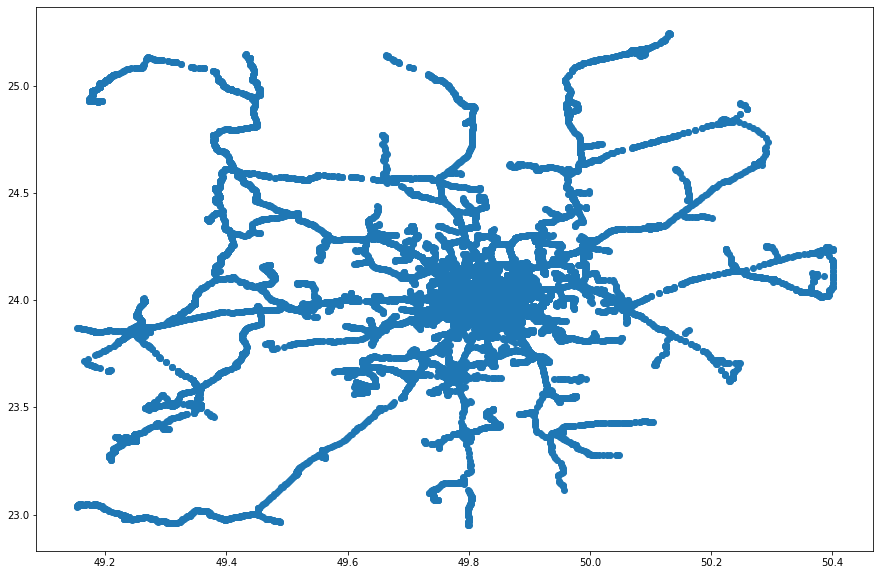

In [74]:
vs = []
xs = []
ys = []
for v in root.findall('N'):
    xs.append(float(v.get('Lat')))
    ys.append(float(v.get('Long')))

cx = np.mean(xs)
cy = np.mean(ys)
print(cx, cy)

plt.figure(figsize=(15, 10))
plt.scatter(xs, ys, label='v')

In [5]:
import math
from haversine import haversine

In [6]:
def get_distances(xs, ys, cx, cy):
    res = []
    for x1, y1 in zip(xs, ys):
        res.append(haversine((x1, y1), (cx, cy)))
    return res

In [7]:
def get_window(x_left, x_right, y_left, y_right):
    res_x, res_y = [], []
    for x, y in zip(xs, ys):
        if x_left <= x <= x_right and y_left <= y <= y_right:
            res_x.append(x)
            res_y.append(y)
    return res_x, res_y

In [8]:
x_win, y_win = get_window(49.75, 49.8, 24.0, 24.15)
dist = get_distances(x_win, y_win, cx, cy)

In [9]:
mx_dist = max(dist)
mx_col = 100

In [46]:
drv1 = (49.76, 24.125)

drv2 = (49.776, 24.075)

zak1 = (49.770, 24.09)

zak2 = (49.79, 24.085)

#zak3 = (49.782, 24.07)
zak3 = (49.782, 24.06)

zak4 = (49.788, 24.05)

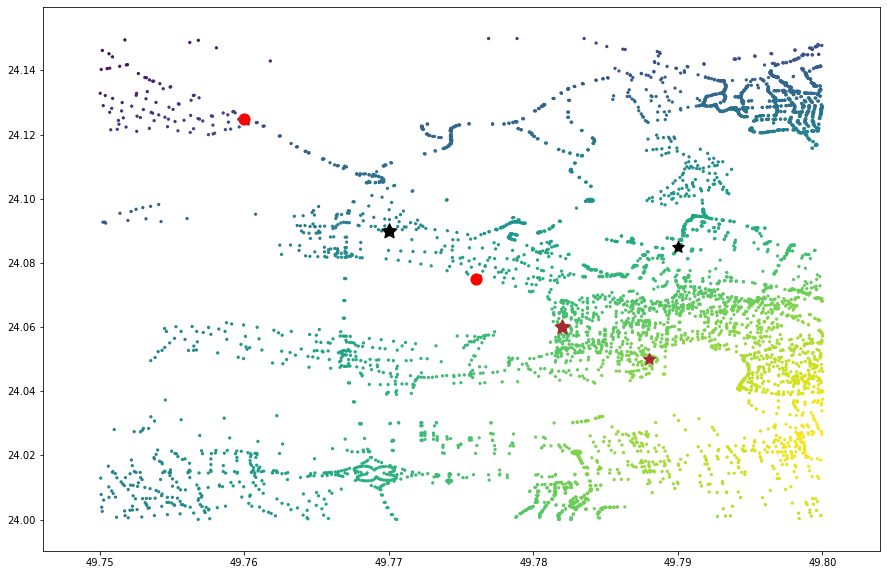

In [66]:
plt.figure(figsize=(15, 10))
plt.scatter(x_win, y_win, label='v', s=5, c=colors)
plt.scatter(drv1[0], drv1[1], label='v', s=125, c='red')
plt.scatter(drv2[0], drv2[1], label='v', s=125, c='red')
plt.scatter(zak1[0], zak1[1], label='v', s=250, c='black', marker=(5, 1))
plt.scatter(zak2[0], zak2[1], label='v', s=150, c='black', marker=(5, 1))
plt.scatter(zak3[0], zak3[1], label='v', s=250, c='brown', marker=(5, 1))
plt.scatter(zak4[0], zak4[1], label='v', s=150, c='brown', marker=(5, 1))

In [48]:
colors = [mx_col * (1 - dis) / mx_dist for dis in dist]

In [49]:
def get_path_array(drv, zak1, zak2):
    fst, _ = some.get_full_path(drv, zak1)
    scd, _ = some.get_full_path(zak1, zak2)
    return list(fst) + list(scd)

In [50]:
arr = get_path_array(drv1, zak1, zak2)
path = get_path_array(drv2, zak3, zak4)
!mkdir image1

mkdir: image1: File exists


In [51]:
def take(arr, i):
    return arr[min(i, len(arr) - 1)]

In [69]:
def make_animation(arr, path, delay):
    for i in range(max(len(arr), len(path) + delay)):
        plt.figure(figsize=(15, 10))
        plt.scatter(x_win, y_win, label='v', s=5, c=colors)
        plt.scatter(take(arr, i)[0], take(arr, i)[1], label='v', s=125, c='red')
        plt.scatter(zak1[0], zak1[1], label='v', s=250, c='black', marker=(5, 1))
        plt.scatter(zak2[0], zak2[1], label='v', s=150, c='black', marker=(5, 1))
        
        if i < delay:
            plt.scatter(drv2[0], drv2[1], label='v', s=125, c='red')
            plt.savefig('image1/f' + str(i) + '.png')
            continue
        plt.scatter(take(path, i - delay)[0], take(path, i - delay)[1], label='v', s=125, c='red')
        plt.scatter(zak3[0], zak3[1], label='v', s=250, c='brown', marker=(5, 1))
        plt.scatter(zak4[0], zak4[1], label='v', s=150, c='brown', marker=(5, 1))
        
        plt.savefig('image1/f' + str(i) + '.png')

In [ ]:
make_animation(arr, path, delay=20)

In [149]:
point_x = [49.769, 49.767, 49.767, 49.838, 49.836, 49.835]
point_y = [24.013, 24.050, 24.085, 24.077, 24.033, 24.000]

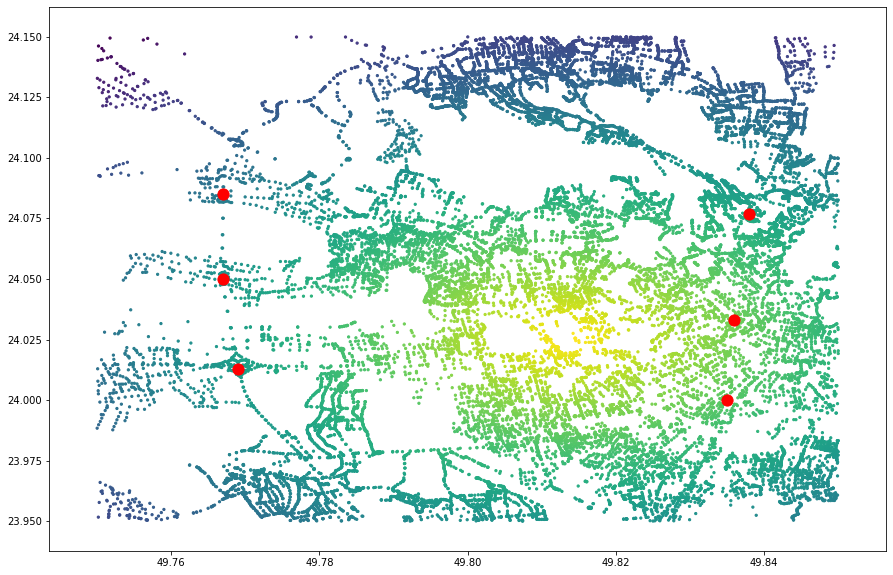

In [150]:
x_win, y_win = get_window(49.75, 49.85, 23.95, 24.15)
dist = get_distances(x_win, y_win, cx, cy)
colors = [mx_col * (1 - dis) / mx_dist for dis in dist]

plt.figure(figsize=(15, 10))
plt.scatter(x_win, y_win, label='v', s=5, c=colors)
plt.scatter(point_x, point_y, s=125, c='red')

In [151]:
def get_arr_by_points(point_x, point_y):
    begin = (point_x[0], point_y[0])
    res = []
    leng = len(point_x)
    for i in range(leng):
        fst, _ = some.get_full_path((point_x[i], point_y[i]), (point_x[(i + 1) % leng], point_y[(i + 1) % leng]))
        res += list(fst)
    return res

In [145]:
array = []

In [146]:
array.append(get_arr_by_points(point_x, point_y))

In [152]:
array.append(get_arr_by_points(point_x[4:] + [point_x[0]], point_y[4:] + [point_y[0]]))

In [153]:
array.append(get_arr_by_points(point_x[2:5], point_y[2:5]))

In [164]:
array.append(get_arr_by_points([point_x[5]] + point_x[:2], [point_y[5]] + point_y[:2]))

In [157]:
array.append(get_arr_by_points(point_x[1:4], point_y[1:4]))

In [170]:
!rm -r image2
!mkdir image2

In [171]:
def make_horovod(array):
    lens = [len(a) for a in array]
    mark_colors = ['black', 'brown', 'red', 'darkgreen', 'crimson']
    for i in range(max(lens)):
        plt.figure(figsize=(15, 10))
        plt.scatter(x_win, y_win, label='v', s=5, c=colors)
        for k, ar in enumerate(array):
            j = i % len(ar)
            plt.scatter(ar[j][0], ar[j][1], s=125, c=mark_colors[k])
        plt.savefig('image2/f' + str(i) + '.png')

In [ ]:
make_horovod(array)